In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
import numpy as np

from torch import optim
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from transform_util import Compose, RandomHorizontalFlip, PILToTensor, ToDtype, RandomPhotometricDistort
from coco_dataset import COCODataset

from utils import *
from make_args import Args

- draw utils

In [2]:
import matplotlib.pyplot as plt

from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps

In [12]:
def draw_bbox(ax, box, box_color, text, color, mask):
    ax.add_patch(
        plt.Rectangle(
            xy=(box[0], box[1]),
            width=box[2] - box[0],
            height=box[3] - box[1],
            fill=False,
            edgecolor=box_color,
            linewidth=2,
        )
    )
    ax.annotate(
        text=text,
        xy=((box[0] + box[2])//2, (box[1] + box[3])//2),
        color='blue',
        weight="bold",
        fontsize=10,
    )

    mask = np.ma.masked_where(mask == 0, mask)
    # mask_color = {"blue": "Blues", "red" : "Reds"}

    cmap = plt.cm.get_cmap(color)
    norm = plt.Normalize(vmin=0, vmax=1)
    rgba = cmap(norm(mask))
    ax.imshow(rgba, interpolation="nearest", alpha=0.5)

- args

In [4]:
args = Args('./config/01_ResNet50FPN_Backbone.json')

- Dataloader

In [5]:
transform = Compose(
    [
        PILToTensor(),
        ToDtype(scale=True, dtype=torch.float)
    ]
)
dataset = COCODataset(args.data_path, train=False, transform=transform)

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!


- Model

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(dataset.new_categories)

weights_path = './model_result/01_ResNet50FPN_Backbone/ResNet50FPN_model.pth'
weights = torch.load(weights_path)

if args.backbone == 'resnet50fpn':
    model = maskrcnn_resnet50_fpn(pretrained_backbone=True) # imagenet pretrained
    model.roi_heads.box_predictor = FastRCNNPredictor(
        in_channels=model.roi_heads.box_predictor.cls_score.in_features,
        num_classes=num_classes
    )
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_channels=model.roi_heads.mask_predictor.conv5_mask.in_channels,
        dim_reduced=args.hidden_layer,
        num_classes=num_classes
    )

model.load_state_dict(weights)
model.to(device)
model.eval()

/home/aicombined/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/home/aicombined/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

- loss check

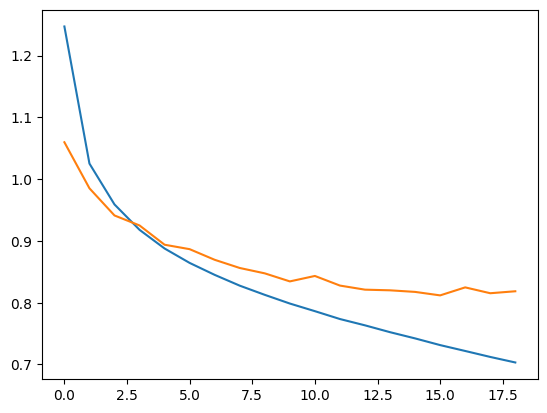

In [7]:
loss_dict = np.load('./model_result/01_ResNet50FPN_Backbone/ResNet50FPN_model.npy', allow_pickle=True).item()

train_loss = loss_dict['train_loss'].copy()
val_loss = loss_dict['val_loss'].copy()

plt.plot(train_loss)
plt.plot(val_loss)

- inference

In [8]:
_cate_dict = dataset.new_categories
cate_dict = {}
for key, value in _cate_dict.items():
    cate_dict[value] = key

color_dict = {}
# color_names = list(mcolors.CSS4_COLORS)
color_names = list(colormaps)
for i in range(len(list(cate_dict.keys()))):
    color_dict[i] = color_names[i]

In [49]:
se_idx = -1400
threshold = 0.5

with torch.no_grad():
    image, target = dataset[se_idx]
    image = [image.to(device)]
    outputs = model(image)

    boxes = outputs[0]["boxes"].to("cpu").numpy()
    masks = outputs[0]["masks"].squeeze(1).to("cpu").numpy()
    labels = outputs[0]["labels"].to("cpu").numpy()
    scores = outputs[0]["scores"].to("cpu").numpy()

    boxes = boxes[scores >= threshold].astype(np.int32)
    masks = masks[scores >= threshold]
    labels = labels[scores >= threshold]
    scores = scores[scores >= threshold]

    # 마스크 처리
    masks[masks >= threshold] = 1.0
    masks[masks < threshold] = 0.0
    
    gtboxes = target["boxes"].numpy()
    gtmasks = target['masks'].numpy()
    gtlabels = target["labels"].numpy()

- gt image

/tmp/ipykernel_10886/3833241738.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(color)


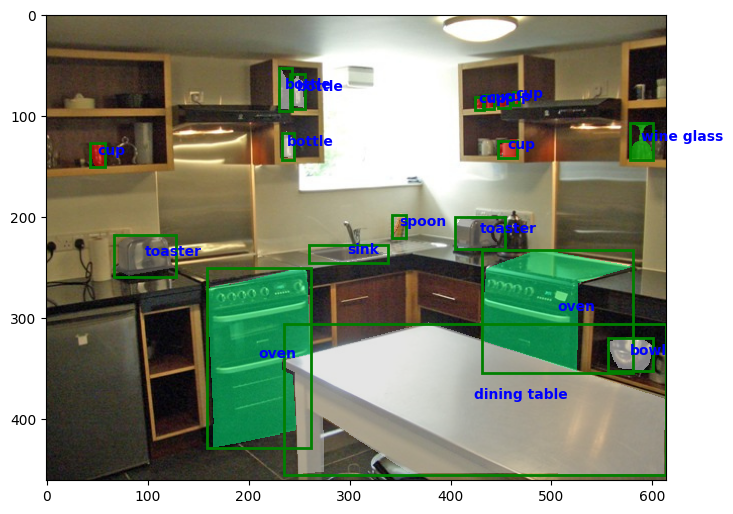

In [50]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(to_pil_image(image[0]))

for box, mask, label in zip(gtboxes, gtmasks, gtlabels):
    draw_bbox(ax, box, 'green', f"{cate_dict[label]}", color_dict[label], mask)

- inference image

/tmp/ipykernel_10886/3833241738.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(color)


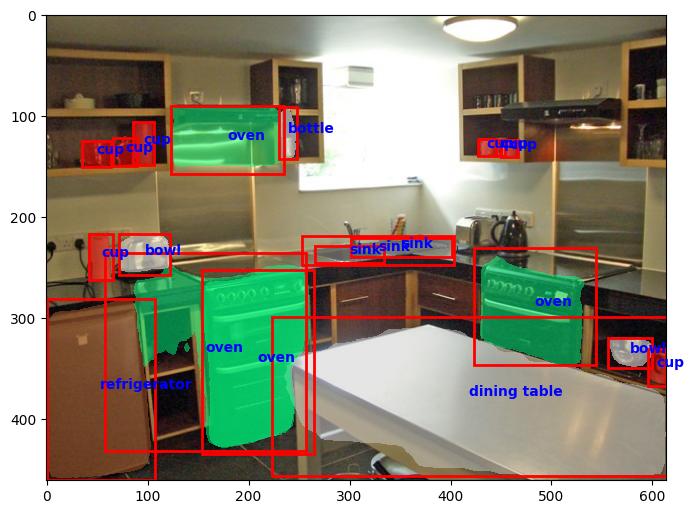

In [51]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
plt.imshow(to_pil_image(image[0]))

for box, mask, label in zip(boxes, masks, labels):
    draw_bbox(ax, box, 'red', f"{cate_dict[label]}", color_dict[label], mask)